In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from openeye import oechem, oedepict, oeomega, oequacpac, oemedchem
from IPython.display import display
import pandas as pd
import oenotebook as oenb
from openmoltools.openeye import get_charges
from openmoltools import openeye
from torsionfit.qmscan.fragment import *
import networkx as nx
from torsionfit.qmscan.enumfrags2pdf import main as vis_wrapper

In [2]:
f = open('../torsion_drive/biphenyl/4phepyr.smi', 'r')
smiles = {}
for line in f:
    smile, name = line.rstrip().split(' ')
    smiles[name] = smile
f.close()

In [3]:
for name in smiles:
    print(name)
    oname = '{}_new.pdf'.format(name)
    
    frags, charged = SmilesToFragments(smiles[name], bondOrderThreshold=1.2)
    frags_combs = GetFragmentAtomBondSetCombinations(frags)
    ToPdf(charged, oname, frags, frags_combs)

4phepyr
2
4phepyrOH_neutral
3
4phepyrOH_anion
2
4phepyrOH_cation
3
4phepyrOH_zwitterion
1
4phepyrF
2
4phepyrFOH_neutral
3
4phepyrFOH_anion
2
4phepyrFOH_cation
3
4phepyrFOH_zwitterion
1


In [4]:
smiles['4phepyr']

'c1cc(ccc1c2ccncc2)'

In [5]:
oemol = openeye.smiles_to_oemol(smiles['4phepyr'])

In [6]:
charged = openeye.get_charges(oemol, keep_confs=1)

In [7]:
G = OeMolToGraph(charged)

In [8]:
G.edge[0][5]

{'aromatic': True, 'index': 0, 'weight': 1.3809841871261597}

In [218]:
imatinib = 'C5=C(C1=CN=CC=C1)N=C(NC2=C(C=CC(=C2)NC(C3=CC=C(C=C3)CN4CCN(CC4)C)=O)C)N=C5'
mol = openeye.smiles_to_oemol(imatinib)
charged = get_charges(mol, keep_confs=1)


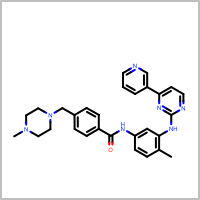

In [219]:
oenb.draw_smiles(imatinib)


In [388]:
def is_hbond(bond):
    hbond = None
    beg = bond.GetBgn()
    end = bond.GetEnd()
    if beg.IsHydrogen() or end.IsHydrogen():
        hbond = bond
    return hbond

def find_ring(a, rot_bond, next_bond, atoms = [], bonds = []):
    if a.GetIdx() not in atoms:
        atoms.append(a.GetIdx())
    for bond in a.GetBonds():
        if bond.IsRotor():
            # I should check for resonance here..
            continue 
        
        if bond.IsInRing() or is_hbond(bond):
            beg = bond.GetBgn()
            end = bond.GetEnd()
            beg_index = beg.GetIdx()
            end_index = end.GetIdx()
            if bond.GetIdx() not in bonds:
                bonds.append(bond.GetIdx())
            if beg_index not in atoms:
                atoms.append(beg_index)
                find_ring(beg, rot_bond, next_bond, atoms, bonds)
            if end_index not in atoms:
                atoms.append(end_index)
                find_ring(end, rot_bond, next_bond, atoms, bonds)
        elif not bond.IsRotor():
            beg_idx = bond.GetBgn().GetIdx()
            end_idx = bond.GetEnd().GetIdx()
            if bond.GetIdx() not in bonds:
                bonds.append(bond.GetIdx())
            if beg_idx not in atoms:
                atoms.append(beg_idx)
            if end_idx not in atoms:
                atoms.append(end_idx)
            
        #elif is_ortho(bond, rot_bond, next_bond):
            # bond is ortho
        #    beg_idx = bond.GetBgn().GetIdx()
        #    end_idx = bond.GetEnd().GetIdx()
        #    if bond.GetIdx() not in bonds:
        #        bonds.append(bond.GetIdx())
        #    if beg_idx not in atoms:
        #        atoms.append(beg_idx)
        #    if end_idx not in atoms:
        #        atoms.append(end_idx)           
    return atoms, bonds

def to_AtomBondSet(mol, atoms, bonds):
    AtomBondSet = oechem.OEAtomBondSet()
    for a_idx in atoms:
        AtomBondSet.AddAtom(mol.GetAtom(oechem.OEHasAtomIdx(a_idx)))
    for b_idx in bonds:
        AtomBondSet.AddBond(mol.GetBond(oechem.OEHasBondIdx(b_idx)))
    return AtomBondSet

def is_ortho(bond, rot_bond, next_bond):
    bond_attached = set()
    rot_attached = set()
    next_attached = set()
    # Check if theese bonds have a connecting bond that's in a ring
    beg_b = bond.GetBgn()
    end_b = bond.GetEnd()
    beg_r = rot_bond.GetBgn()
    end_r = rot_bond.GetEnd()
    beg_n = next_bond.GetBgn()
    end_n = next_bond.GetEnd()
    for b in beg_b.GetBonds():
        bond_attached.add(b.GetIdx())
    for b in end_b.GetBonds():
        bond_attached.add(b.GetIdx())        
    for b in beg_r.GetBonds():
        rot_attached.add(b.GetIdx())
    for b in end_r.GetBonds():
        rot_attached.add(b.GetIdx())
    for b in beg_n.GetBonds():
        next_attached.add(b.GetIdx())
    for b in end_n.GetBonds():
        next_attached.add(b.GetIdx())
    intersection = (bond_attached & rot_attached)
    if not bool(intersection):
        # Check if it's ortho to next bond
        intersection = (bond_attached & next_attached)
    return bool(intersection)
    

In [437]:
def build_frag(bond, mol, atoms=set(), bonds=set()):
    b_idx = bond.GetIdx()
    if b_idx not in bonds:
        bonds.add(b_idx)
    beg = bond.GetBgn()
    end = bond.GetEnd()
    beg_idx = beg.GetIdx()
    end_idx = end.GetIdx()
    #if beg_idx not in atoms:
    atoms.add(beg_idx)
    for atom in beg.GetAtoms():
        a_idx = atom.GetIdx()
        atoms.add(a_idx)
        next_bond = mol.GetBond(atom, beg)
        nb_idx = next_bond.GetIdx()
        if nb_idx != b_idx and nb_idx not in bonds:
            bonds.add(nb_idx)
            if a_idx != end_index:
                if atom.IsInRing():
                    r_atoms, r_bonds = find_ring(atom, rot_bond=bond, next_bond=next_bond, atoms=[], bonds=[])
                    for a_idx in r_atoms:
                        atoms.add(a_idx)
                    for b_idx in r_bonds:
                        bonds.add(b_idx) 
                if next_bond.GetData('WibergBondOrder') >= 1.2:
                    print('resonance: {}'.format(next_bond))
                    build_frag(next_bond, mol, atoms, bonds)
    #if end_idx not in atoms:
    atoms.add(end_idx)
    for atom in end.GetAtoms():
        a_idx = atom.GetIdx()
        atoms.add(a_idx)
        next_bond = mol.GetBond(atom, end)
        nb_idx = next_bond.GetIdx()
        if nb_idx != b_idx and nb_idx not in bonds:
            bonds.add(nb_idx)
            if a_idx != beg_index:
                if atom.IsInRing():
                    r_atoms, r_bonds = find_ring(atom, rot_bond=bond, next_bond=next_bond, atoms=[], bonds=[])
                    for a_idx in r_atoms:
                        atoms.add(a_idx)
                    for b_idx in r_bonds:
                        bonds.add(b_idx)
                if next_bond.GetData('WibergBondOrder') >= 1.2:
                    print('resonance: {}'.format(next_bond))
                    build_frag(next_bond, mol, atoms, bonds)
                    
                  #  print(nbr)
                #if next_bond.GetData('WibergBondOrder') >= 1.2:
                #    print('resonance: {}'.format(next_bond))
                #    build_frag(next_bond, mol, atoms, bonds)
    return atoms, bonds
                
                
                
    #if end_idx not in atoms:
    #    atoms.add(end_idx)
    #for atom in beg.GetAtoms():
    #    a_idx = atoms.GetIdx()
    #    atoms.add(a_idx)
    #    next_bond = mol.GetBond(atom, beg)
        
    
    

In [438]:
frags = []
for bond in charged.GetBonds():
    if bond.IsRotor():
        print(bond)
        atoms, bonds = build_frag(bond, charged, atoms=set(), bonds=set())
        atom_bond_set = to_AtomBondSet(charged, atoms, bonds)
        frags.append(atom_bond_set)

 2 (1C-2C)
resonance:  1 (0C-1C)
resonance:  3 (2C-7C)
11 (9C-10N)
resonance: 10 (8N-9C)
12 (10N-11C)
resonance: 13 (11C-16C)
19 (15C-17N)
resonance: 17 (14C-15C)
20 (17N-18C)
resonance: 37 (18C-33O)
21 (18C-19C)
resonance: 37 (18C-33O)
resonance: 22 (19C-24C)
28 (22C-25C)
resonance: 25 (21C-22C)
29 (25C-26N)


In [439]:
frags = []
for bond in charged.GetBonds():
    if bond.IsRotor():
        print(bond)
        atoms, bonds = build_frag(bond, charged)
        print(atoms)
        print(bonds)
        
        beg = bond.GetBgn()
        end = bond.GetEnd()
        beg_index = beg.GetIdx()
        end_index = end.GetIdx()
        atom_bond_set = oechem.OEAtomBondSet()
        atom_bond_set.AddBond(bond)
        atom_bond_set.AddAtom(beg)
        atom_bond_set.AddAtom(end)
        
        for atom in beg.GetAtoms():
            atom_bond_set.AddAtom(atom)
            next_bond = charged.GetBond(atom, beg)
            atom_bond_set.AddBond(next_bond)
            if atom.GetIdx() != end_index:
                if atom.IsInRing():
                    atoms, bonds = find_ring(atom, rot_bond=bond, next_bond=next_bond, atoms=[], bonds=[])
                    for a_idx in atoms:
                        atom_bond_set.AddAtom(charged.GetAtom(oechem.OEHasAtomIdx(a_idx)))
                    for b_idx in bonds:
                        atom_bond_set.AddBond(charged.GetBond(oechem.OEHasBondIdx(b_idx)))
                # Check for functional group - only stop checking if it's a c-c bond. 
                if not atom.IsCarbon():
                    
                #find_ortho(atoms, bonds, charged.GetBond(atom, beg), charged)
            
                
        for atom in end.GetAtoms():
            atom_bond_set.AddAtom(atom)
            next_bond = charged.GetBond(atom, end)
            atom_bond_set.AddBond(next_bond)
            if atom.GetIdx() != beg_index:
                if atom.IsInRing():
                    atoms, bonds = find_ring(atom, rot_bond=bond, next_bond=next_bond, atoms=[], bonds=[])
                    for a_idx in atoms:
                        atom_bond_set.AddAtom(charged.GetAtom(oechem.OEHasAtomIdx(a_idx)))
                    for b_idx in bonds:
                        atom_bond_set.AddBond(charged.GetBond(oechem.OEHasBondIdx(b_idx)))
        frags.append(atom_bond_set)

IndentationError: expected an indented block (<ipython-input-439-b5bd9af804ba>, line 35)

In [440]:
is_ortho(charged.GetBond(oechem.OEHasBondIdx(9)), charged.GetBond(oechem.OEHasBondIdx(11)))

TypeError: is_ortho() missing 1 required positional argument: 'next_bond'

In [441]:
(b & r) is not None

True

In [442]:
# Convert fragments to smile strings
def frag_to_smiles(frags, mol):
    smiles = []
    for frag in frags:
        fragatompred = oechem.OEIsAtomMember(frag.GetAtoms())
        fragbondpred = oechem.OEIsBondMember(frag.GetBonds())

        fragment = oechem.OEGraphMol()
        adjustHCount = True
        oechem.OESubsetMol(fragment, mol, fragatompred, fragbondpred, adjustHCount)
        smiles.append(oechem.OEMolToSmiles(fragment))
        #print(OEMolToSmiles(fragment))
    return smiles

In [443]:
smiles = frag_to_smiles(frags, charged)

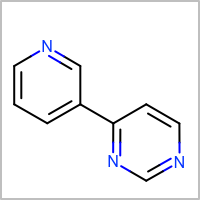

In [444]:
oenb.draw_smiles(smiles[0])

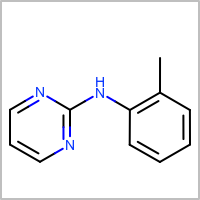

In [445]:
oenb.draw_smiles(smiles[1])

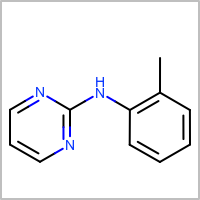

In [446]:
oenb.draw_smiles(smiles[2])

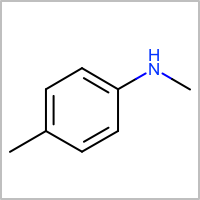

In [447]:
oenb.draw_smiles(smiles[3])

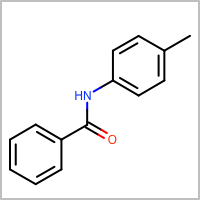

In [448]:
oenb.draw_smiles(smiles[4])

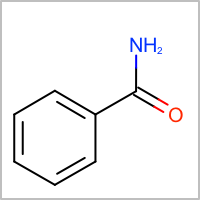

In [449]:
oenb.draw_smiles(smiles[5])

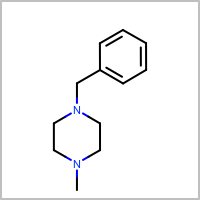

In [450]:
oenb.draw_smiles(smiles[6])

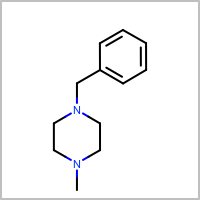

In [451]:
oenb.draw_smiles(smiles[7])

In [333]:
test_simple ="c1cc(N)cc(S(=O)(=O)O)c1" 
mol = oechem.OEGraphMol()
oechem.OESmilesToMol(mol, imatinib)
oedepict.OEPrepareDepiction(mol)

width, height = 300, 200

opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
opts.SetAtomPropertyFunctor(oedepict.OEDisplayAtomIdx())
opts.SetAtomPropLabelFont(oedepict.OEFont(oechem.OEDarkGreen))

disp = oedepict.OE2DMolDisplay(mol, opts)
oedepict.OERenderMolecule("AtomPropIndexImatininb.png", disp)

True

In [30]:
mol = oechem.OEGraphMol()
oechem.OESmilesToMol(mol, test_simple)
oedepict.OEPrepareDepiction(mol)

width, height = 300, 200

opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
opts.SetAtomPropertyFunctor(oedepict.OEDisplayAtomIdx())
opts.SetAtomPropLabelFont(oedepict.OEFont(oechem.OEDarkGreen))

disp = oedepict.OE2DMolDisplay(mol, opts)
oedepict.OERenderMolecule("AtomPropIndex.png", disp)

True

In [71]:
oname = 'test5.pdf'
frags_combs = GetFragmentAtomBondSetCombinations(frags)
ToPdf(charged, oname, frags, frags_combs)

0

In [72]:
imatinib = 'C5=C(C1=CN=CC=C1)N=C(NC2=C(C=CC(=C2)NC(C3=CC=C(C=C3)CN4CCN(CC4)C)=O)C)N=C5'

In [371]:
print(bond)

 2 (1C-2C)


In [367]:
bond.GetNbr(atom)

In [366]:
print(atom)

36 C


In [372]:
atom = charged.GetAtom(oechem.OEHasAtomIdx(1))

TypeError: 'OEAtomBase' object is not iterable

In [369]:
bond

<oechem.OEBondBase; proxy of <Swig Object of type 'OEChem::OEBondBase *' at 0x11e4a2420> >